# Review of "Generating 3 qubit quantum circuits with neural networks"

Chris Ferrie

This is an open peer review of arxiv:1703.10743, [Generating 3 qubit quantum circuits with neural networks](https://arxiv.org/abs/1703.10743) by Michael Swaddle *et al*.

**TO JOURNAL EDITORS:** You are free to use the contents of the [repository](https://github.com/csferrie/openreviews) as you see fit.

**DISCLAIMER:** A referee necessarily spends *far* less time than the authors on the paper. As such, this report surely contains errors. I would love for you to point them out so I can correct them. Otherwise, this report is provided without warranty of any kind, including its suitability as a resource for making decisions affecting the career of the authors of the paper.

## Tweetable summary of my report

Highly recommended read for its accessibility and reproducibility, but lacks the analysis to live up to its claims. #workinprogress

### Summary of claims and results

The authors seem to define quantum compilation the same way I would define *quantum control*. Namely, given a set of control Hamiltonians, design the interaction strength to generate a target unitary. The standard approach—as far as I understand—is a numerical gradient-based optimization using classical simulation to evaluate the objective function. The authors propose the following two-step alternative:
* First break up the path from the the initial gate to the target into sequence of unitaries which approximate a geodesic curve in $SU(d)$;
* Second, for each of those unitaries, find the set of controls to achieve those, with the idea that—given they are "close" together—it should be easier than traditional approaches.

The authors achieve this to some extend by training a neural network with simulated trajectories. Though, as I outline below, much more analysis is required to warrant suggesting this as a viable alternative to traditional methods. Though they did *not* emphasize it, I see the provided code and data as the most valuable research output.

### Correctness

Given I was able to reproduce the results, I have no doubt the results obtained are correct. I do have some concerns, though, in the relevance of the result to quantum control:
* The authors seem to truncate the unitaries to the real part of each entry. Are two unitaries that are close in their real part actually close? I don't think they are.
* The training data for the second stage control problem does not use the the gates generated from the first part. They simply generate random controls to define a target. It would be far more convincing if the gates used in the first stage where used in the second stage. After all, this is how it would necessarily be done in practice.

### Accessibility

The paper is quite short, but not necessarily dense. I am neither an expert in geometric quantum nor the architecture of neural networks—yet, I was able to quickly grasp the main idea of the paper. That being said, there were a few points which I got hung up on. 
* The discussion of the problem of quantum compilation, or control, lacks context. It attempts to be broad, but would leave a non-expert thinking: a good approximation to $U$ is of course $U$. It should be discussed earlier—and made explicit—hat the basis for the sub-algebra is somehow an experimental constraint or set of available controls. 
* The crucial part of the geodesic equation seems to be the projection onto the sub-algebra. This should be explicitly defined.
* The network design is lacking everything but a bare description—why this rather than something else? Is there some intuition at least?
* Fidelity is the standard metric used in quantum control (and something like diamond norm is the ultimate figure of merit for quantum gate comparisons). The real part of the individual entries seems to be quite difficult to justify from an operational perspective. Such choices need to be explained and defended.

### Reproducibility

Relative to other research in quantum information theory, this work gets top marks for reproducibility. However... given the author's eagerness to go above and beyond what is expected in a physics paper, I'm going to make some further suggestions for improvement in the hopes that the reproducibility aspect is more transparent.

The code is not well organized or documented. Since it is quite minimal and I had some basic knowledge in the software used, I was able to figure out how it works. But, I doubt most of the target audience of this paper could make use of it. Indeed, I immediately ran into errors when attempting to run the code, making the saved trained model useless to me. To be fair, I did not attempt to contact the authors about this since—as the authors themselves point out—the model can be trained quite quickly on a reasonable GPU (as you will see below).

The data was generated with separate software—Mathematica. I do not have a Mathematica license so did not attempt to reproduce the data. Given the authors were already using numpy, it would have been straightforward to generate the data in python as well.

### Methodology

I think here is where the paper falls short. The analysis of the results of the network training are not subjected to any anaylsis beyond plotting the results. Crucially(!):
* How does this method compare to existing methods for:
    * The geodesic approach?
    * The local decomposition?
* Further to that, does the claim that the lack of redundancy using the geodesic provides an effective alternative hold up to numerical tests? (It would be straightforward given the infrastructure the authors have build to test the claims of their own paper!)
* (Even for the small examples) How do the results depend on the parameters of the neural network?

### Final verdict

The authors provided the code to generate the data, the data themselves, the code to train the network, and the trained network!  Indeed, if I was so inclined, I could immediately build on their work without any uncertainty and this is far more than I can say for anything else I've read recently on [quant-ph]([https://arxiv.org/list/quant-ph/recent). This is an immensely impressive effort in a field which neither rewards or encourages it. The standard approach to publishing is to obscure your result to the point of either not being about to reproduce it, or give yourself plausible deniability should it be wrong. I applaud the authors for their bravery in exposing their work for detailed criticism. 

I see this as a (very useful!) set of lab notes rather than a complete scientific result because of the lack of comparisons to existing methods and variations in the proposed method. More analysis and discussion of the results is required. 

### Reproducibility analysis

The code here is derived from the source provided by the authors at https://github.com/Swaddle/nnQcompiler.

I have also used the data provided by the authors at https://github.com/Swaddle/nnQcompiler.

I had a bit of trouble with various versions and their respective compatability under Python 3:
```
Python 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)] on linux
```
With the Anaconda distribution above, I download Keras version 1.2.2 and ran:
```
pip install tensorflow
pip install Keras-1.2.2.tar.gz
```

I hacked up some minimal changes and moved most of the code into this single notebook for convenience. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from data_utils import load_data_lstm, load_data_ss

from keras.models import Sequential
from keras.metrics import mean_squared_error
from keras.layers import Dense, Dropout, Flatten
from keras.layers.recurrent import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import ZeroPadding1D
from keras.callbacks import CSVLogger
from tensorflow.python.ops import control_flow_ops
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

Using TensorFlow backend.


The authors use the squared error as an objective. While standard in many network training problems, it is unclear what it's operational meaning is here.

In [2]:
def custom_objective(y_true, y_pred):
    tensor = y_true - y_pred 
    squares = tf.square(tensor)
    norm = tf.reduce_sum(squares)
    return norm

The authors already nicely split the training and validation data, so we just load that up.

In [3]:
training_data_path = 'data/lstm_data_training.csv'
valid_data_path = 'data/lstm_data_valid.csv'

train_input, train_output = load_data_lstm(training_data_path)
valid_input, valid_output = load_data_lstm(valid_data_path)

This seems like black magic to me and is worth playing with, but it defines the architecture of the network.

In [4]:
model = Sequential()

model.add(GRU(80, return_sequences=True, input_shape=(8,8)))
model.add(Dropout(0.2))
model.add(GRU(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(80, return_sequences=True))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(input_dim=640,output_dim=640))

#model.summary()

Now we train that sucker!

In [5]:
%%time

model.compile(optimizer='Nadam',loss=custom_objective)
history = model.fit(train_input, train_output, validation_data=(valid_input,valid_output), nb_epoch=1000, batch_size=64)

Train on 1000 samples, validate on 100 samples
Epoch 1/1000
1000/1000 [==============================] - 1s - loss: 1655.0847 - val_loss: 34.2073
Epoch 2/1000
1000/1000 [==============================] - 0s - loss: 316.0393 - val_loss: 18.3714
Epoch 3/1000
1000/1000 [==============================] - 0s - loss: 169.6186 - val_loss: 16.4331
Epoch 4/1000
1000/1000 [==============================] - 0s - loss: 93.3592 - val_loss: 10.5343
Epoch 5/1000
1000/1000 [==============================] - 0s - loss: 108.5998 - val_loss: 11.2147
Epoch 6/1000
1000/1000 [==============================] - 0s - loss: 62.0827 - val_loss: 10.4611
Epoch 7/1000
1000/1000 [==============================] - 0s - loss: 52.4477 - val_loss: 9.0723
Epoch 8/1000
1000/1000 [==============================] - 0s - loss: 77.2306 - val_loss: 12.8944
Epoch 9/1000
1000/1000 [==============================] - 0s - loss: 42.5482 - val_loss: 8.8110
Epoch 10/1000
1000/1000 [==============================] - 0s - loss: 45.2898

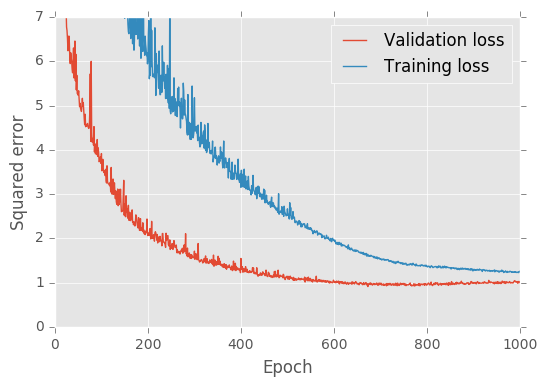

In [6]:
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.plot(history.history['loss'], label = 'Training loss')

plt.ylabel("Squared error")
plt.xlabel("Epoch")

plt.ylim([0,7])
plt.legend();

That looks nearly identical to Fig. 1 of [the paper](https://arxiv.org/abs/1703.10743). Next, the "local decomposition."

In [7]:
training_data_path = 'data/ss_data_training.csv'
valid_data_path = 'data/ss_data_valid.csv'

train_input, train_output = load_data_ss(training_data_path)
valid_input, valid_output = load_data_ss(valid_data_path)

In [8]:
model = Sequential()

model.add(Dense(output_dim=2000,input_dim=64))

model.add(Dense(4000,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4000,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(input_dim=4000,output_dim=36))

#model.summary()

In [9]:
%%time

model.compile(optimizer='adam',loss=custom_objective)

history = model.fit(train_input, train_output, validation_data=(valid_input,valid_output), nb_epoch=500, batch_size=64)

Train on 500 samples, validate on 500 samples
Epoch 1/500
500/500 [==============================] - 2s - loss: 1928.0432 - val_loss: 58.7284
Epoch 2/500
500/500 [==============================] - 1s - loss: 83.0015 - val_loss: 56.8443
Epoch 3/500
500/500 [==============================] - 1s - loss: 57.4910 - val_loss: 48.1649
Epoch 4/500
500/500 [==============================] - 1s - loss: 51.7076 - val_loss: 47.2014
Epoch 5/500
500/500 [==============================] - 1s - loss: 49.7511 - val_loss: 47.0593
Epoch 6/500
500/500 [==============================] - 1s - loss: 49.4571 - val_loss: 46.9361
Epoch 7/500
500/500 [==============================] - 1s - loss: 48.8565 - val_loss: 46.5122
Epoch 8/500
500/500 [==============================] - 1s - loss: 48.1984 - val_loss: 46.0242
Epoch 9/500
500/500 [==============================] - 1s - loss: 47.9599 - val_loss: 45.4773
Epoch 10/500
500/500 [==============================] - 1s - loss: 47.1162 - val_loss: 45.5617
Epoch 11/50

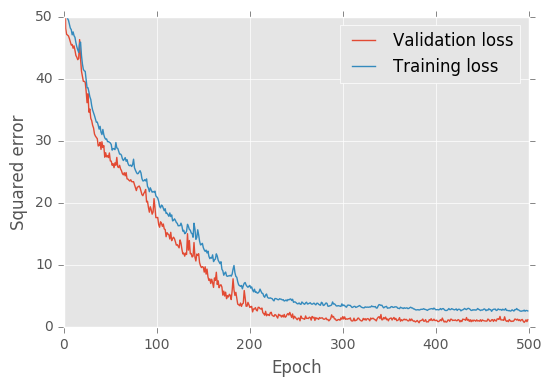

In [10]:
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.plot(history.history['loss'], label = 'Training loss')

plt.ylabel("Squared error")
plt.xlabel("Epoch")

plt.ylim([0,50])
plt.legend();

Great! I say, at the level of trusting their data, these results are reproducible!